# DataDiagnostics - Development of a Diabetes Prediction Model using Machine Learning
#### Dataset source: https://www.kaggle.com/datasets/tigganeha4/diabetes-dataset-2019

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras-tuner

In [ ]:
%matplotlib inline
# Import necessary libraries

# Initial Imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt

In [ ]:
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [ ]:
!pip install -q kaggle
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
kaggle_token_path = '/content/drive/My Drive/kaggle.json'
kaggle_dir = '/root/.kaggle/'

# Check if kaggle directory exists, if not, create it
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Copy kaggle.json from Google Drive to appropriate directory
if os.path.exists(kaggle_token_path):
    shutil.copy(kaggle_token_path, kaggle_dir)
    os.chmod(kaggle_dir + 'kaggle.json', 600)

# Download dataset from Kaggle
!kaggle datasets download -d tigganeha4/diabetes-dataset-2019

# Unzip the dataset
!unzip -o diabetes-dataset-2019.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
diabetes-dataset-2019.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  diabetes-dataset-2019.zip
  inflating: diabetes_dataset__2019.csv  


In [ ]:
# Initialize Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Kaggle_Dataset") \
    .getOrCreate()

# Load dataset into Spark DataFrame
df = spark.read.csv('diabetes_dataset__2019.csv', header=True, inferSchema=True)
df.show()

+------------+------+---------------+------+--------------------+---+-------+-------+-----+----------+---------------+------------+----------+-------+----------+---------+------------+--------+
|         Age|Gender|Family_Diabetes|highBP|    PhysicallyActive|BMI|Smoking|Alcohol|Sleep|SoundSleep|RegularMedicine|    JunkFood|    Stress|BPLevel|Pregancies|Pdiabetes|UriationFreq|Diabetic|
+------------+------+---------------+------+--------------------+---+-------+-------+-----+----------+---------------+------------+----------+-------+----------+---------+------------+--------+
|       50-59|  Male|             no|   yes|      one hr or more| 39|     no|     no|    8|       6.0|             no|occasionally| sometimes|   high|         0|        0|    not much|      no|
|       50-59|  Male|             no|   yes|less than half an hr| 28|     no|     no|    8|       6.0|            yes|  very often| sometimes| normal|         0|        0|    not much|      no|
|       40-49|  Male|         

In [ ]:
# Show schema to confirm date type
df.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Family_Diabetes: string (nullable = true)
 |-- highBP: string (nullable = true)
 |-- PhysicallyActive: string (nullable = true)
 |-- BMI: integer (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Sleep: integer (nullable = true)
 |-- SoundSleep: double (nullable = true)
 |-- RegularMedicine: string (nullable = true)
 |-- JunkFood: string (nullable = true)
 |-- Stress: string (nullable = true)
 |-- BPLevel: string (nullable = true)
 |-- Pregancies: integer (nullable = true)
 |-- Pdiabetes: string (nullable = true)
 |-- UriationFreq: string (nullable = true)
 |-- Diabetic: string (nullable = true)



In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
df = df.toPandas()

# Remove leading and trailing spaces from all column names
df.columns = df.columns.str.strip()

# Set the option to display all columns
pd.options.display.max_columns = None

# Show the first few rows of the DataFrame
df.head()

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6.0,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6.0,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8.0,no,occasionally,sometimes,normal,0.0,0,not much,no


# Data Preprocessing Steps

In [ ]:
# Spelling corrections
df = df.rename(columns={'Family_Diabetes': 'FamilyDiabetes', 'Pregancies':'Pregnancies', 'Pdiabetes': 'GDiabetes', 'UriationFreq': 'UrinationFreq'})
df.head()

,Age,Gender,FamilyDiabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6.0,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6.0,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8.0,no,occasionally,sometimes,normal,0.0,0,not much,no


In [ ]:
# Drop the column 'highBP'
df = df.drop(columns=['highBP'])
df.head()

,Age,Gender,FamilyDiabetes,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq,Diabetic
0,50-59,Male,no,one hr or more,39.0,no,no,8,6.0,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,less than half an hr,28.0,no,no,8,6.0,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,one hr or more,24.0,no,no,6,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,one hr or more,23.0,no,no,8,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,less than half an hr,27.0,no,no,8,8.0,no,occasionally,sometimes,normal,0.0,0,not much,no


In [ ]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Age                  0
Gender               0
FamilyDiabetes       0
PhysicallyActive     0
BMI                  4
Smoking              0
Alcohol              0
Sleep                0
SoundSleep           0
RegularMedicine      0
JunkFood             0
Stress               0
BPLevel              0
Pregnancies         42
GDiabetes            1
UrinationFreq        0
Diabetic             1
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               952 non-null    object 
 1   Gender            952 non-null    object 
 2   FamilyDiabetes    952 non-null    object 
 3   PhysicallyActive  952 non-null    object 
 4   BMI               948 non-null    float64
 5   Smoking           952 non-null    object 
 6   Alcohol           952 non-null    object 
 7   Sleep             952 non-null    int32  
 8   SoundSleep        952 non-null    float64
 9   RegularMedicine   952 non-null    object 
 10  JunkFood          952 non-null    object 
 11  Stress            952 non-null    object 
 12  BPLevel           952 non-null    object 
 13  Pregnancies       910 non-null    float64
 14  GDiabetes         951 non-null    object 
 15  UrinationFreq     952 non-null    object 
 16  Diabetic          951 non-null    object 
dt

In [ ]:
# Drop rows with missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 951
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               905 non-null    object 
 1   Gender            905 non-null    object 
 2   FamilyDiabetes    905 non-null    object 
 3   PhysicallyActive  905 non-null    object 
 4   BMI               905 non-null    float64
 5   Smoking           905 non-null    object 
 6   Alcohol           905 non-null    object 
 7   Sleep             905 non-null    int32  
 8   SoundSleep        905 non-null    float64
 9   RegularMedicine   905 non-null    object 
 10  JunkFood          905 non-null    object 
 11  Stress            905 non-null    object 
 12  BPLevel           905 non-null    object 
 13  Pregnancies       905 non-null    float64
 14  GDiabetes         905 non-null    object 
 15  UrinationFreq     905 non-null    object 
 16  Diabetic          905 non-null    object 
dtypes:

In [ ]:
# Display summary statistics of numerical columns
df.describe().round()

,BMI,Sleep,SoundSleep,Pregnancies
count,905.0,905.0,905.0,905.0
mean,26.0,7.0,6.0,0.0
std,5.0,1.0,2.0,1.0
min,15.0,4.0,0.0,0.0
25%,22.0,6.0,4.0,0.0
50%,24.0,7.0,6.0,0.0
75%,28.0,8.0,7.0,0.0
max,45.0,11.0,11.0,4.0


# Compute the correlation matrix on the entire DataFrame

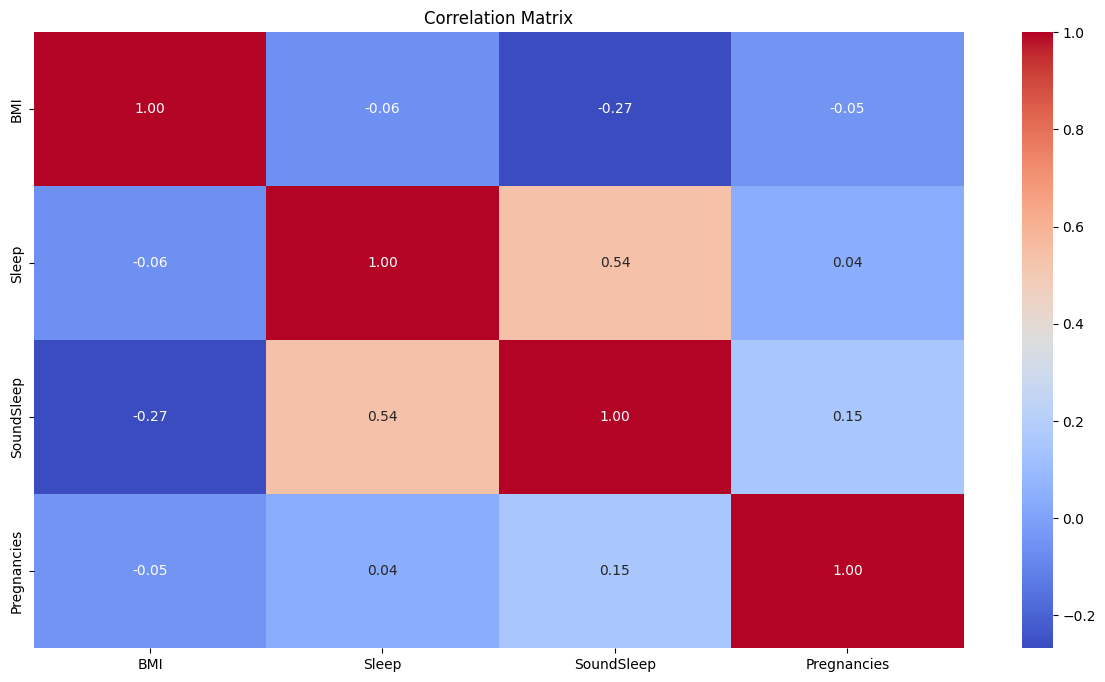

In [ ]:
# Drop non-numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix on the numeric DataFrame
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# For binary categorical variables, convert 'yes' to 1 and 'no' to 0

In [ ]:
# Print the counts of unique values in the 'Gender' column
print(df['Gender'].value_counts())

# Print the counts of unique values in the 'FamilyDiabetes' column
print(df['FamilyDiabetes'].value_counts())

# Print the counts of unique values in the 'Smoking' column
print(df['Smoking'].value_counts())

# Print the counts of unique values in the 'Alcohol' column
print(df['Alcohol'].value_counts())

# Print the counts of unique values in the 'RegularMedicine' column
print(df['RegularMedicine'].value_counts())

# Print the counts of unique values in the 'Diabetic' column
print(df['Diabetic'].value_counts())

# Print the counts of unique values in the 'Gdiabetes' column
print(df['GDiabetes'].value_counts())

Gender
Male      562
Female    343
Name: count, dtype: int64
FamilyDiabetes
no     472
yes    433
Name: count, dtype: int64
Smoking
no     799
yes    106
Name: count, dtype: int64
Alcohol
no     718
yes    187
Name: count, dtype: int64
RegularMedicine
no     581
yes    323
o        1
Name: count, dtype: int64
Diabetic
no     641
yes    263
 no      1
Name: count, dtype: int64
GDiabetes
0      891
yes     14
Name: count, dtype: int64


In [ ]:
# Display concise summary information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 951
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               905 non-null    object 
 1   Gender            905 non-null    object 
 2   FamilyDiabetes    905 non-null    object 
 3   PhysicallyActive  905 non-null    object 
 4   BMI               905 non-null    float64
 5   Smoking           905 non-null    object 
 6   Alcohol           905 non-null    object 
 7   Sleep             905 non-null    int32  
 8   SoundSleep        905 non-null    float64
 9   RegularMedicine   905 non-null    object 
 10  JunkFood          905 non-null    object 
 11  Stress            905 non-null    object 
 12  BPLevel           905 non-null    object 
 13  Pregnancies       905 non-null    float64
 14  GDiabetes         905 non-null    object 
 15  UrinationFreq     905 non-null    object 
 16  Diabetic          905 non-null    object 
dtypes:

In [ ]:
# For binary categorical variables, convert 'yes' to 1 and 'no' to 0

binary_cols = ['FamilyDiabetes', 'Smoking', 'Alcohol']
for col in binary_cols:
    df[col] = df[col].map({'no': 0, 'yes': 1})

# Convert 'o' in 'RegularMedicine' to 0
df['RegularMedicine'] = df['RegularMedicine'].map({'no': 0, 'yes': 1, 'o': 0})

# Convert 'no' to 0 and 'yes' to 1 in 'Diabetic', handling possible leading/trailing whitespaces
df['Diabetic'] = df['Diabetic'].map({'no': 0, 'yes': 1, ' no': 0})

# Convert '0' to 0 and 'yes' to 1 in 'GDiabetes'
df['GDiabetes'] = df['GDiabetes'].map({'0': 0, 'yes': 1})

# Convert 'Male' to 0 and 'Female' to 1 in 'Gender'
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Display the DataFrame head to inspect the changes
df.head()

,Age,Gender,FamilyDiabetes,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq,Diabetic
0,50-59,0,0,one hr or more,39.0,0,0,8,6.0,0,occasionally,sometimes,high,0.0,0,not much,0
1,50-59,0,0,less than half an hr,28.0,0,0,8,6.0,1,very often,sometimes,normal,0.0,0,not much,0
2,40-49,0,0,one hr or more,24.0,0,0,6,6.0,0,occasionally,sometimes,normal,0.0,0,not much,0
3,50-59,0,0,one hr or more,23.0,0,0,8,6.0,0,occasionally,sometimes,normal,0.0,0,not much,0
4,40-49,0,0,less than half an hr,27.0,0,0,8,8.0,0,occasionally,sometimes,normal,0.0,0,not much,0


In [ ]:
# Print the counts of unique values in the 'Gender' column
print(df['Gender'].value_counts())

# Print the counts of unique values in the 'FamilyDiabetes' column
print(df['FamilyDiabetes'].value_counts())

# Print the counts of unique values in the 'Smoking' column
print(df['Smoking'].value_counts())

# Print the counts of unique values in the 'Alcohol' column
print(df['Alcohol'].value_counts())

# Print the counts of unique values in the 'RegularMedicine' column
print(df['RegularMedicine'].value_counts())

# Print the counts of unique values in the 'Diabetic' column
print(df['Diabetic'].value_counts())

# Print the counts of unique values in the 'GDiabetes' column
print(df['GDiabetes'].value_counts())

Gender
0    562
1    343
Name: count, dtype: int64
FamilyDiabetes
0    472
1    433
Name: count, dtype: int64
Smoking
0    799
1    106
Name: count, dtype: int64
Alcohol
0    718
1    187
Name: count, dtype: int64
RegularMedicine
0    582
1    323
Name: count, dtype: int64
Diabetic
0    642
1    263
Name: count, dtype: int64
GDiabetes
0    891
1     14
Name: count, dtype: int64


In [ ]:
# Print the counts of unique values in the 'Age' column
print(df['Age'].value_counts())

# Print the counts of unique values in the 'PhysicallyActive' column
print(df['PhysicallyActive'].value_counts())

# Print the counts of unique values in the 'JunkFood' column
print(df['JunkFood'].value_counts())

# Print the counts of unique values in the 'Stress' column
print(df['Stress'].value_counts())

# Print the counts of unique values in the 'BPLevel' column
print(df['BPLevel'].value_counts())

# Print the counts of unique values in the 'UrinationFreq' column
print(df['UrinationFreq'].value_counts())

Age
less than 40    462
40-49           153
50-59           148
60 or older     142
Name: count, dtype: int64
PhysicallyActive
less than half an hr    317
more than half an hr    251
one hr or more          208
none                    129
Name: count, dtype: int64
JunkFood
occasionally    633
often           176
very often       52
always           44
Name: count, dtype: int64
Stress
sometimes     530
very often    158
not at all    131
always         86
Name: count, dtype: int64
BPLevel
normal     667
high       205
low         25
High         5
Low          2
normal       1
Name: count, dtype: int64
UrinationFreq
not much       642
quite often    263
Name: count, dtype: int64


In [ ]:
# Map categorical ordinal values to numerical values for 'Age'
df['Age'] = df['Age'].map({'less than 40': 0, '40-49': 1, '50-59': 2, '60 or older': 3})

# Map categorical ordinal values to numerical values for 'PhysicallyActive'
df['PhysicallyActive'] = df['PhysicallyActive'].map({'none': 0, 'less than half an hr': 1, 'more than half an hr': 2, 'one hr or more': 3})

# Map categorical ordinal values to numerical values for 'JunkFood'
df['JunkFood'] = df['JunkFood'].map({'occasionally': 0, 'often': 1, 'very often': 2, 'always': 3})

# Map categorical ordinal values to numerical values for 'Stress'
df['Stress'] = df['Stress'].map({'not at all': 0, 'sometimes': 1, 'very often': 2, 'always': 3})

# Map categorical ordinal values to numerical values for 'BPLevel'
df['BPLevel'] = df['BPLevel'].map({'low': 0, 'Low': 0, 'normal': 1, 'normal ': 1, 'high': 2, 'High': 2})

# Map categorical ordinal values to numerical values for 'UrinationFreq'
df['UrinationFreq'] = df['UrinationFreq'].map({'not much': 0, 'quite often': 1})

# Display the DataFrame head to inspect the changes
df.head()

,Age,Gender,FamilyDiabetes,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq,Diabetic
0,2,0,0,3,39.0,0,0,8,6.0,0,0,1,2,0.0,0,0,0
1,2,0,0,1,28.0,0,0,8,6.0,1,2,1,1,0.0,0,0,0
2,1,0,0,3,24.0,0,0,6,6.0,0,0,1,1,0.0,0,0,0
3,2,0,0,3,23.0,0,0,8,6.0,0,0,1,1,0.0,0,0,0
4,1,0,0,1,27.0,0,0,8,8.0,0,0,1,1,0.0,0,0,0


In [ ]:
# Print the counts of unique values for the 'Age' column after mapping categorical ordinal values to numerical values
print(df['Age'].value_counts())

# Print the counts of unique values for the 'PhysicallyActive' column after mapping categorical ordinal values to numerical values
print(df['PhysicallyActive'].value_counts())

# Print the counts of unique values for the 'JunkFood' column after mapping categorical ordinal values to numerical values
print(df['JunkFood'].value_counts())

# Print the counts of unique values for the 'Stress' column after mapping categorical ordinal values to numerical values
print(df['Stress'].value_counts())

# Print the counts of unique values for the 'BPLevel' column after mapping categorical ordinal values to numerical values
print(df['BPLevel'].value_counts())

# Print the counts of unique values for the 'UrinationFreq' column after mapping categorical ordinal values to numerical values
print(df['UrinationFreq'].value_counts())

Age
0    462
1    153
2    148
3    142
Name: count, dtype: int64
PhysicallyActive
1    317
2    251
3    208
0    129
Name: count, dtype: int64
JunkFood
0    633
1    176
2     52
3     44
Name: count, dtype: int64
Stress
1    530
2    158
0    131
3     86
Name: count, dtype: int64
BPLevel
1    668
2    210
0     27
Name: count, dtype: int64
UrinationFreq
0    642
1    263
Name: count, dtype: int64


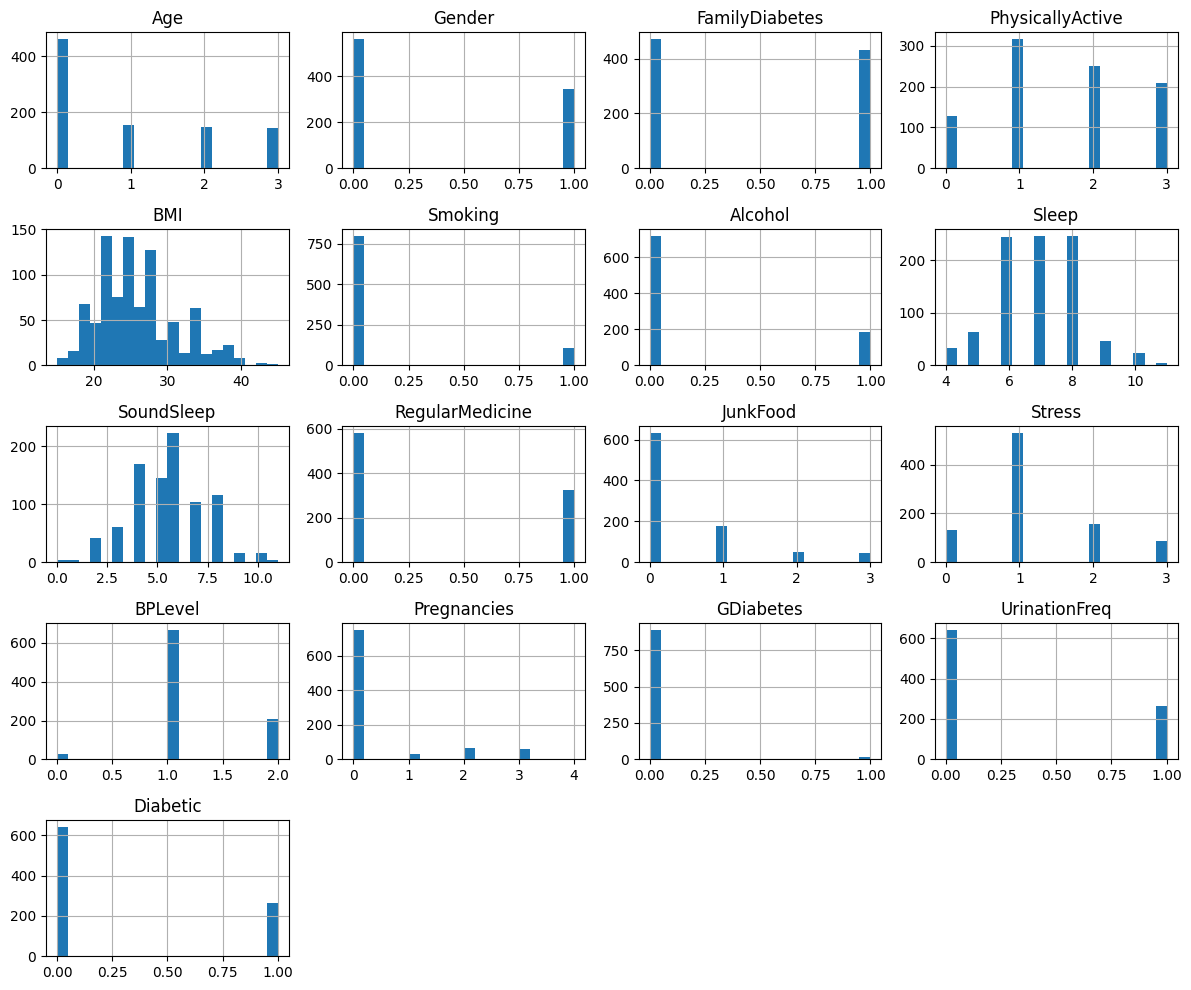

In [ ]:
# Explore distributions of numerical variables using histograms
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

In [ ]:
# Print the data types of columns in the DataFrame
df.dtypes

Age                   int64
Gender                int64
FamilyDiabetes        int64
PhysicallyActive      int64
BMI                 float64
Smoking               int64
Alcohol               int64
Sleep                 int32
SoundSleep          float64
RegularMedicine       int64
JunkFood              int64
Stress                int64
BPLevel               int64
Pregnancies         float64
GDiabetes             int64
UrinationFreq         int64
Diabetic              int64
dtype: object

In [ ]:
# Display the first few rows of the DataFrame to inspect the data
df.head()

,Age,Gender,FamilyDiabetes,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq,Diabetic
0,2,0,0,3,39.0,0,0,8,6.0,0,0,1,2,0.0,0,0,0
1,2,0,0,1,28.0,0,0,8,6.0,1,2,1,1,0.0,0,0,0
2,1,0,0,3,24.0,0,0,6,6.0,0,0,1,1,0.0,0,0,0
3,2,0,0,3,23.0,0,0,8,6.0,0,0,1,1,0.0,0,0,0
4,1,0,0,1,27.0,0,0,8,8.0,0,0,1,1,0.0,0,0,0


In [ ]:
# Export processed DataFrame to a CSV file
df.to_csv("processed_dataset.csv")

# Target and Feature Variables

In [ ]:
# Split the data into features (X) and target variable (y)
X = df.drop('Diabetic', axis=1)
# Define target vector
y = df["Diabetic"].values.reshape(-1, 1)
y = y.ravel()

In [ ]:
# Display the processed DataFrame
print("\nProcessed DataFrame:")
X.head()


Processed DataFrame:


,Age,Gender,FamilyDiabetes,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,GDiabetes,UrinationFreq
0,2,0,0,3,39.0,0,0,8,6.0,0,0,1,2,0.0,0,0
1,2,0,0,1,28.0,0,0,8,6.0,1,2,1,1,0.0,0,0
2,1,0,0,3,24.0,0,0,6,6.0,0,0,1,1,0.0,0,0
3,2,0,0,3,23.0,0,0,8,6.0,0,0,1,1,0.0,0,0
4,1,0,0,1,27.0,0,0,8,8.0,0,0,1,1,0.0,0,0


In [ ]:
print("\nTarget variable:")
y[:5]


Target variable:


array([0, 0, 0, 0, 0])

## Training and testing of datasets

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Logistic Regression Model

In [ ]:
# Creating the logistic regression instance
model = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,123,9
Diabetes Present,17,32


-------------------------------------------
Accuracy Score : 0.856353591160221
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.88      0.93      0.90       132
Diabetes Present       0.78      0.65      0.71        49

        accuracy                           0.86       181
       macro avg       0.83      0.79      0.81       181
    weighted avg       0.85      0.86      0.85       181



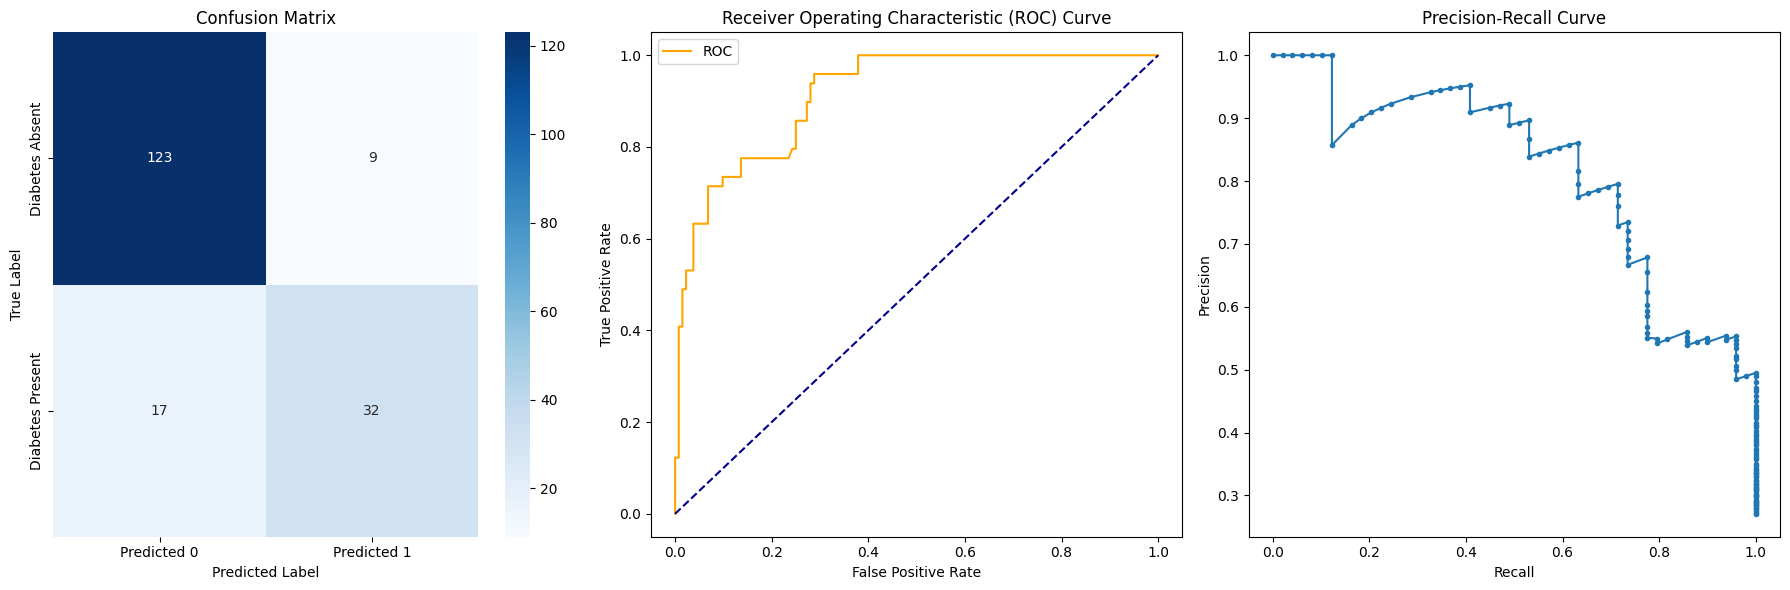

In [ ]:
# Making predictions and calculating probabilities using the testing data
predictions = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of the positive class

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## Random Forest Model

In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Calculating the confusion matrix
predictions = rf_model.predict(X_test_scaled)

In [ ]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix


,Predicted 0,Predicted 1
Diabetes Absent,129,3
Diabetes Present,4,45


Accuracy Score : 0.9613259668508287
Classification Report
                  precision    recall  f1-score   support

 Diabetes Absent       0.97      0.98      0.97       132
Diabetes Present       0.94      0.92      0.93        49

        accuracy                           0.96       181
       macro avg       0.95      0.95      0.95       181
    weighted avg       0.96      0.96      0.96       181



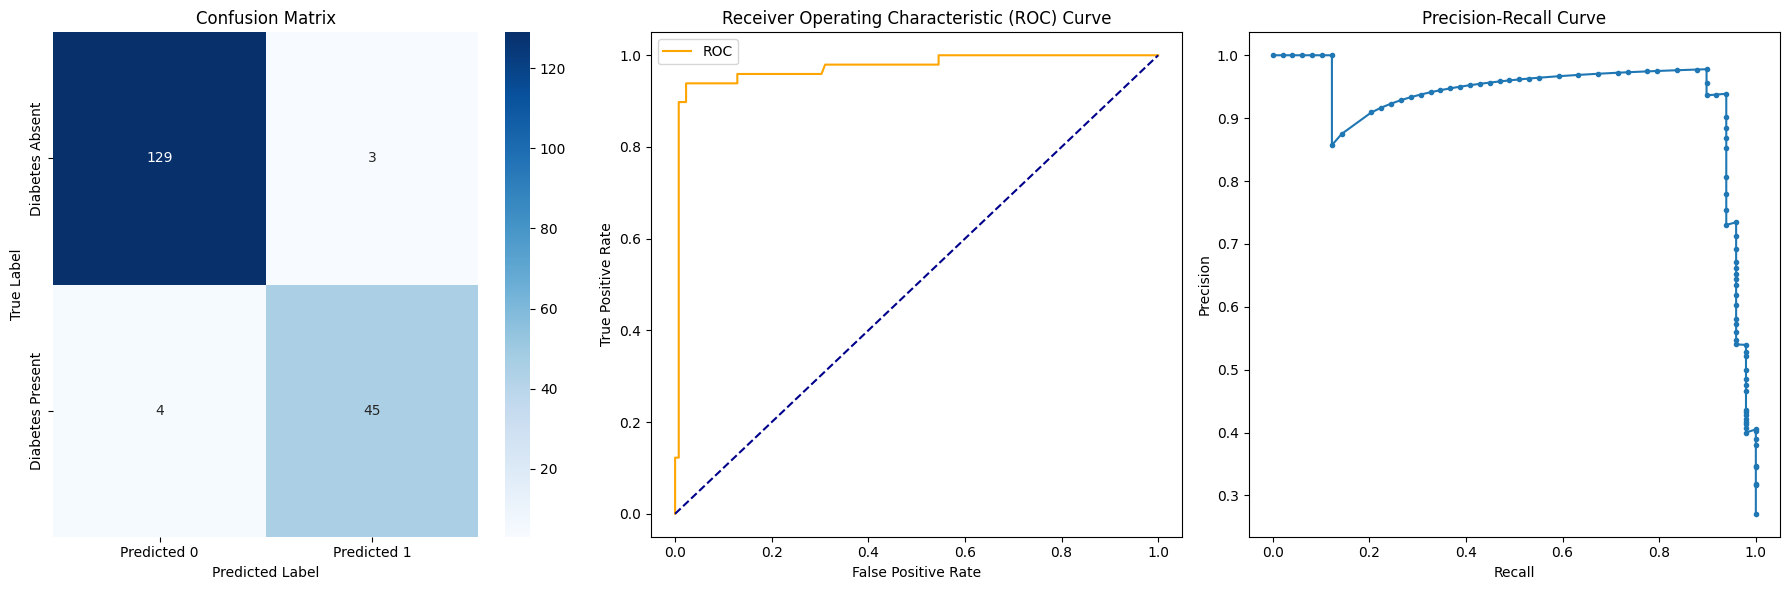

In [ ]:
# Making predictions and calculating probabilities using the testing data
predictions = rf_model.predict(X_test_scaled)
probs = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of the positive class

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## Feature Importances

In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.2147193803614288, 'RegularMedicine'),
 (0.1928953337993035, 'Age'),
 (0.09938605013004329, 'BMI'),
 (0.08050178614559256, 'BPLevel'),
 (0.06842361885358886, 'SoundSleep'),
 (0.060149452982332874, 'Stress'),
 (0.052529473499167666, 'PhysicallyActive'),
 (0.05032690752473751, 'Sleep'),
 (0.05026228331724988, 'FamilyDiabetes'),
 (0.030537069487590763, 'Pregnancies'),
 (0.02363231196590122, 'JunkFood'),
 (0.02131443135083549, 'GDiabetes'),
 (0.016854395060983657, 'UrinationFreq'),
 (0.01606889726766374, 'Gender'),
 (0.015391897634557181, 'Alcohol'),
 (0.007006710619022987, 'Smoking')]

<Axes: title={'center': 'Feature Importances'}, ylabel='1'>

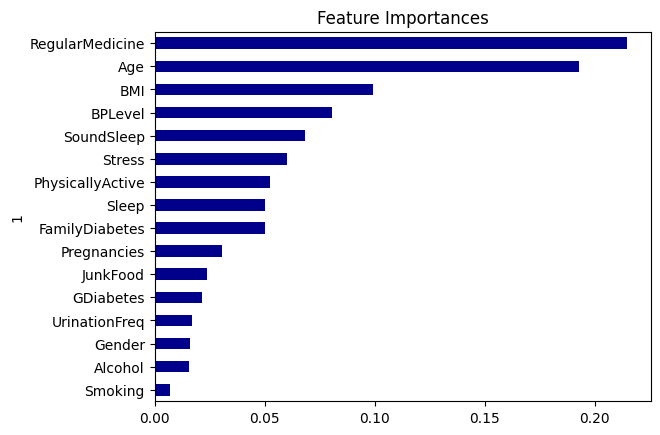

In [ ]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='darkblue', title= 'Feature Importances', legend=False)

## Decision Tree Model

In [ ]:
# Creating the decision tree classifier instance
model = DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,130,2
Diabetes Present,5,44


-------------------------------------------
Accuracy Score : 0.9613259668508287
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.96      0.98      0.97       132
Diabetes Present       0.96      0.90      0.93        49

        accuracy                           0.96       181
       macro avg       0.96      0.94      0.95       181
    weighted avg       0.96      0.96      0.96       181



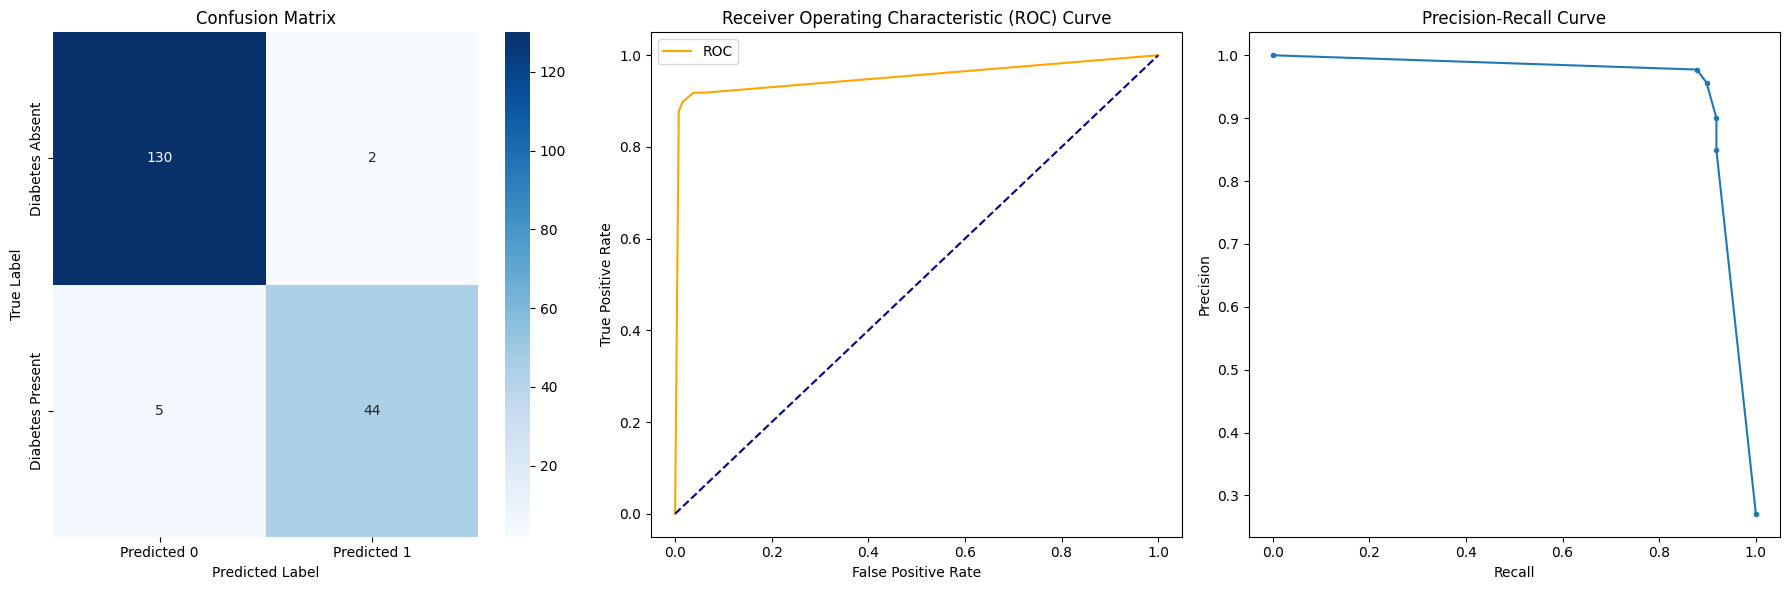

In [ ]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Support Vector Machine (SVM) Model

In [ ]:
# Creating the SVC classifier instance
model = SVC(kernel='linear')

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,123,9
Diabetes Present,14,35


-------------------------------------------
Accuracy Score : 0.8729281767955801
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.90      0.93      0.91       132
Diabetes Present       0.80      0.71      0.75        49

        accuracy                           0.87       181
       macro avg       0.85      0.82      0.83       181
    weighted avg       0.87      0.87      0.87       181



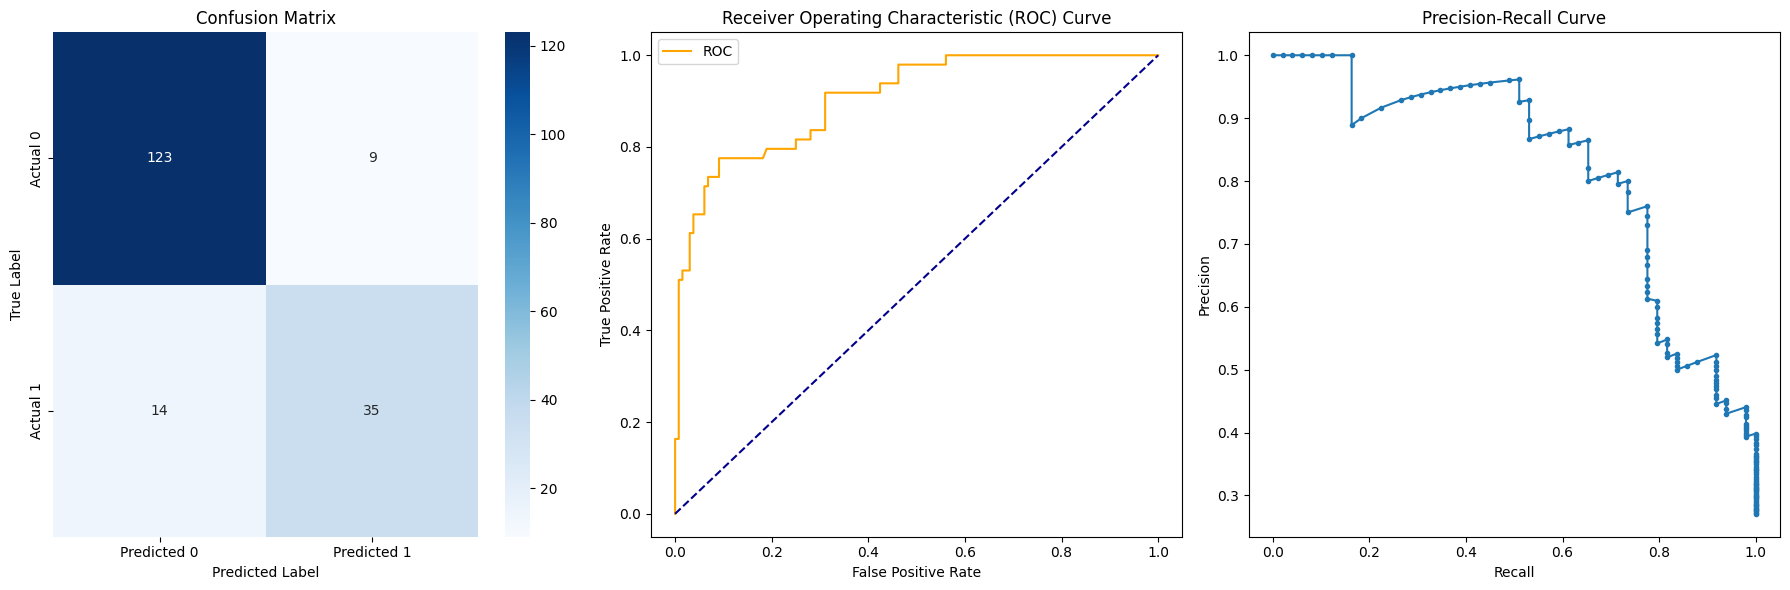

In [ ]:
# Calculating probabilities for ROC curve and precision-recall curve
probs = model.decision_function(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## K-Nearest Neighbors (KNN) Model

In [ ]:
# Creating the decision tree classifier instance
model = KNeighborsClassifier(n_neighbors=3)

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,129,3
Diabetes Present,4,45


-------------------------------------------
Accuracy Score : 0.9613259668508287
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.97      0.98      0.97       132
Diabetes Present       0.94      0.92      0.93        49

        accuracy                           0.96       181
       macro avg       0.95      0.95      0.95       181
    weighted avg       0.96      0.96      0.96       181



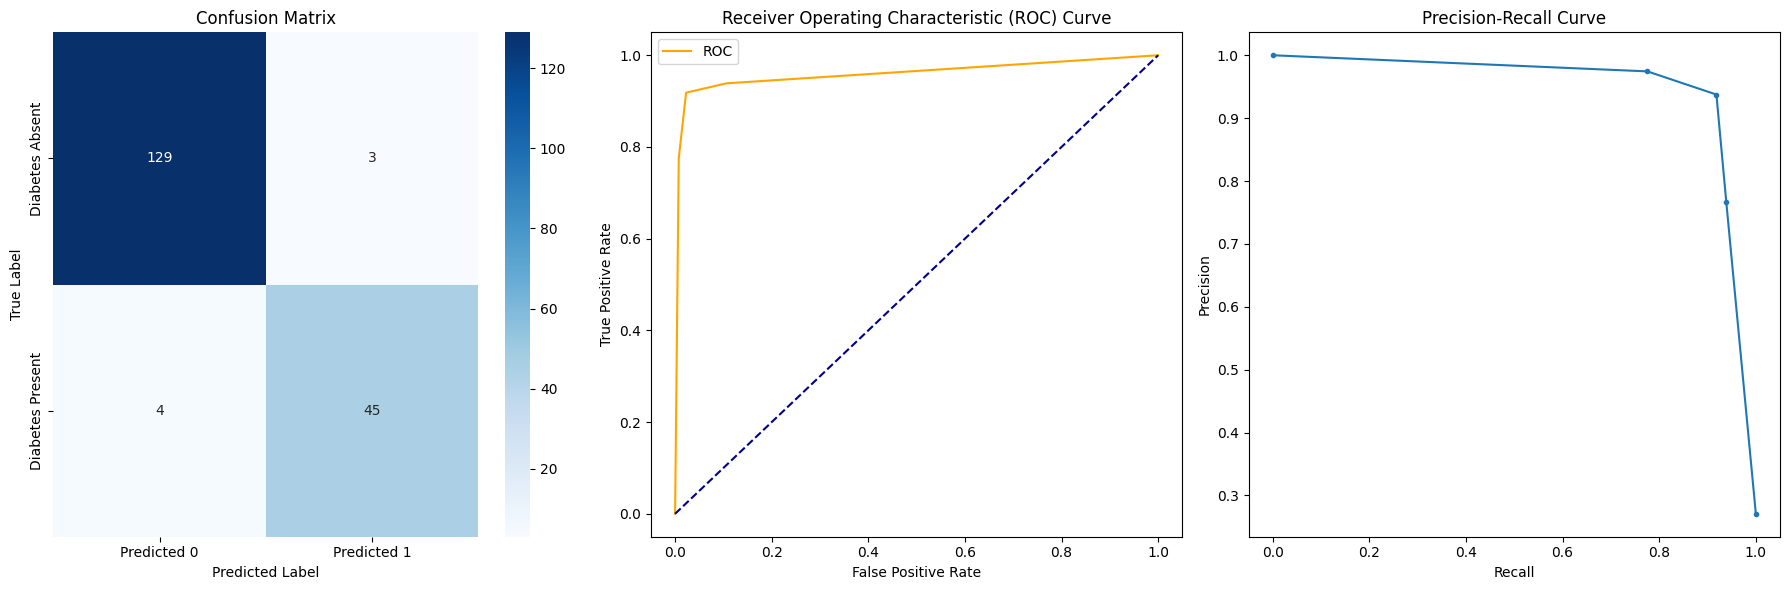

In [ ]:
# Calculating probabilities for ROC curve and precision-recall curve
probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning with GridSearchCV

In [ ]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

In [ ]:
# Define hyperparameter grids for each classifier
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
}

In [ ]:
# Perform Grid Search Cross Validation for each classifier
results = {}
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    results[name] = {'best_params': best_params, 'best_accuracy': best_accuracy}

In [ ]:
# Print results
for name, result in results.items():
    print(f"{name}:")
    print("Best Parameters:", result['best_params'])
    print("Best Accuracy:", result['best_accuracy'])
    print()

Logistic Regression:
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy: 0.8632854406130267

Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.9488984674329501

Decision Tree:
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.9475095785440614

SVM:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Best Accuracy: 0.9350670498084291

KNN:
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
Best Accuracy: 0.9530459770114943



# Neural Network Model

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define input shape based on the shape of X_train
input_shape = X_train_scaled.shape[1]

In [ ]:
# Define a function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('input_units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))  # Adjust dropout rate
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        activation_choice = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation=activation_choice))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))  # Adjust dropout rate
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='accuracy',
                     max_epochs=25,
                     factor=3,
                     directory='keras_tuner_logs',
                     project_name='diabetes_prediction')

# Search for the best hyperparameters without validation data
tuner.search(X_train_scaled, y_train, epochs=30, verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model on the training data
history = model.fit(X_train_scaled, y_train, epochs=30, verbose=1)

Reloading Tuner from keras_tuner_logs/diabetes_prediction/tuner0.json
Epoch 1/30
23/23 [==============================] - 2s 13ms/step - loss: 0.4152 - accuracy: 0.8122
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 0.2702 - accuracy: 0.8771
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.2264 - accuracy: 0.9061
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 0.2046 - accuracy: 0.9227
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1625 - accuracy: 0.9282
Epoch 6/30
23/23 [==============================] - 0s 12ms/step - loss: 0.1810 - accuracy: 0.9171
Epoch 7/30
23/23 [==============================] - 0s 18ms/step - loss: 0.1358 - accuracy: 0.9434
Epoch 8/30
23/23 [==============================] - 0s 17ms/step - loss: 0.1187 - accuracy: 0.9489
Epoch 9/30
23/23 [==============================] - 0s 16ms/step - loss: 0.1340 - accuracy: 0.9392
Epoch 10/30
23/23 [====================

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model_weights.h5")

6/6 [==============================] - 0s 4ms/step - loss: 0.2549 - accuracy: 0.9724
Test Loss: 0.2548755705356598
Test Accuracy: 0.9723756909370422


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

6/6 - 0s - loss: 0.2549 - accuracy: 0.9724 - 37ms/epoch - 6ms/step
Test Loss: 0.2548755705356598, Test Accuracy: 0.9723756909370422


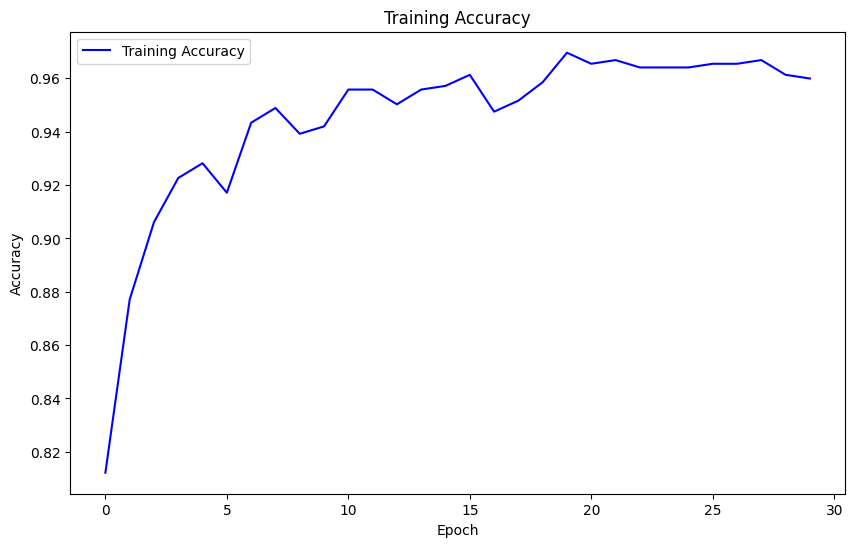

In [ ]:
# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

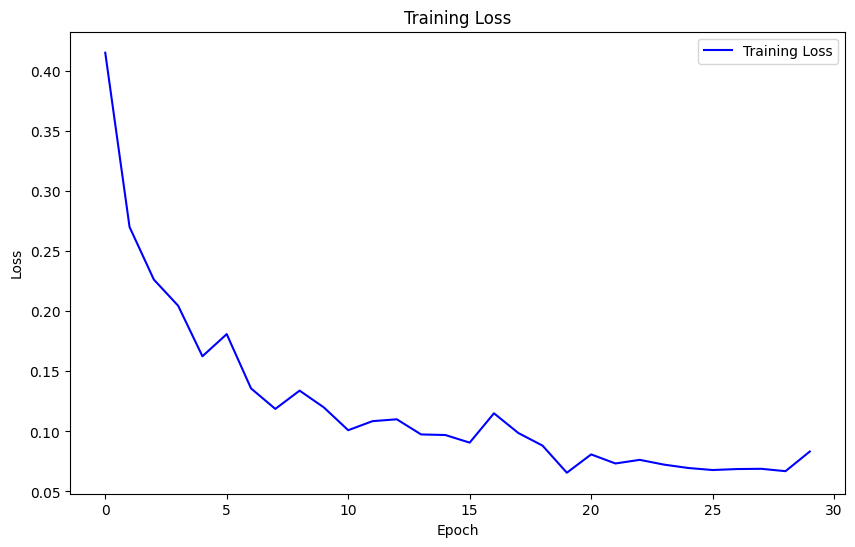

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Assuming y_pred contains the raw predictions and y_true contains the true labels
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
y_true = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Compute and print accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {accuracy}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Diabetes Absent", "Diabetes Present"]))

6/6 [==============================] - 0s 4ms/step
Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,131,1
Diabetes Present,4,45


-------------------------------------------
Accuracy Score : 0.9723756906077348
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.97      0.99      0.98       132
Diabetes Present       0.98      0.92      0.95        49

        accuracy                           0.97       181
       macro avg       0.97      0.96      0.96       181
    weighted avg       0.97      0.97      0.97       181



6/6 [==============================] - 0s 4ms/step


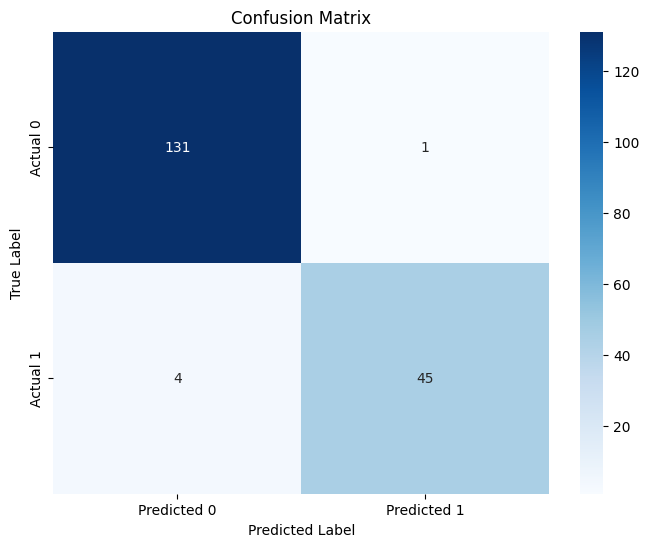

In [ ]:
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")  # Apply threshold for binary classification
y_true = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Summary Report: Machine Learning Models for Diabetes Prediction

This report evaluates the performance of various machine learning models in predicting the presence or absence of diabetes using a provided dataset. The models considered include Logistic Regression, Random Forest, Decision Tree, Support Vector Machine (SVM), K-Nearest Neighbors (KNN), and Neural Network.

| Model | Accuracy | Precision (Diabetes Absent) | Precision (Diabetes Present) | Recall (Diabetes Absent) | Recall (Diabetes Present) | F1-score (Diabetes Absent) | F1-score (Diabetes Present) |
| --- | --- | --- | --- | --- | --- | --- | --- |
| **Logistic Regression** | 85.64% | 88% | 78% | 93% | 65% | 90% | 71% |
| **Random Forest** | 96.13% | 97% | 94% | 98% | 92% | 97% | 93% |
| **Decision Tree** | 96.13% | 96% | 96% | 98% | 90% | 97% | 93% |
| **SVM** | 87.29% | 90% | 80% | 93% | 71% | 91% | 75% |
| **KNN** | 96.13% | 97% | 94% | 98% | 92% | 97% | 93% |
| **Neural Network (optimised)** | 97.24% | 97% | 98% | 99% | 92% | 98% | 95% |

### **Hyperparameter Tuning with GridSearchCV**

| Model | Best Parameters | Best Accuracy |
| --- | --- | --- |
| **Logistic Regression** | {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'} | 86.33% |
| **Random Forest** | {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} | 94.89% |
| **Decision Tree** | {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2} | 94.75% |
| **SVM** | {'C': 10, 'gamma': 'scale', 'kernel': 'poly'} | 93.51% |
| **KNN** | {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'} | 95.30% |


## Conclusion:

The exploration into developing a diabetes prediction model using machine learning techniques has provided valuable insights. The Neural Network model emerges as the most accurate and balanced performer in predicting Type 2 Diabetes, closely followed by Random Forest, Decision Tree, and KNN, which also demonstrate promising results. However, SVM and Logistic Regression exhibit comparatively lower accuracy and performance.

Through analysis with Random Forest, we identified the top three features influencing predictions: RegularMedicine, Age, and BMI.

Hyperparameter tuning using GridSearchCV notably enhanced the performance of SVM and marginally improved Logistic Regression, although for Decision Tree, Random Forest, and KNN, the tuning process showed diminishing returns, with no significant improvements observed.

Considering computational resources, the Neural Network model stands out as the recommended choice for accurate and reliable diabetes prediction, with Random Forest, Decision Tree, and KNN remaining viable alternatives due to their balanced accuracy and efficiency.

Additionally, the development of a user-friendly web application enhances accessibility to the predictive model, allowing users to input health parameters and receive diabetes risk predictions along with explanatory insights. This web application provides an intuitive interface for users, further contributing to the dissemination of the predictive tool in practical healthcare settings.